In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
from suntimes import SunTimes  

In [11]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ERA5_pd_SOS.csv').dropna()
ds_inputs_DE = ds_inputs_DE.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_DE = ds_inputs_DE.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days#, 'D'
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 30] #30


In [13]:
def get_categories(anthesis_date):
    return np.array([anthesis_date < n for n in range(183)]).squeeze().astype(np.int64)
cats = ds_inputs_DE[['observed time to beginning of flowering']].apply(get_categories, args = (), axis = 1)
cats_unlisted = cats.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
cats_unlisted = cats_unlisted.rename(columns = {n: f'dev stage at day {n}' for n in range(183)})
ds_inputs_DE = ds_inputs_DE.merge(cats_unlisted, left_index=True, right_index = True)

In [55]:
ds_inputs_DE = ds_inputs_DE2

In [16]:
def NDVI_from_PD(inputs):
    offset = (inputs[0] - inputs[1]).days
    return inputs[(2 + offset):(202 + offset)].values

In [12]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_8window_MODIS_DE_with_mask.csv')
#ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds_inputs_DE = pd.merge(ds_LSP_DE, ds_inputs_DE, on=['Stations_Id', 'year'], how='outer')
ds_inputs_DE = ds_inputs_DE.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs_DE = loc_and_SOS(ds_inputs_DE, predictor_type='savgol_raw').dropna()
with warnings.catch_warnings(action="ignore"):
    ds_inputs_DE = interpolate_columns(ds_inputs_DE, 270, 'NDVI', resolution=8)
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 0]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['NDVI interpolated at day 0'] >= 0]

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\ML_algorithms\ML_fctns.py:134: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [6]:
ds_inputs_DE.dropna()

,Unnamed: 0_x,year,Stations_Id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 8,NDVI interpolated at day 16,NDVI interpolated at day 24,NDVI interpolated at day 32,NDVI interpolated at day 40,...,t2m at day 302,t2m at day 303,t2m at day 304,t2m at day 305,t2m at day 306,t2m at day 307,t2m at day 308,t2m at day 309,observed time to beginning of flowering,observed time to beginning of tilling sowing drilling
19,188.0,2018.0,7521.0,2018-02-18,0.320304,0.323722,0.330771,0.341449,0.371024,0.384390,...,6.313155,7.020536,4.221992,2.506822,3.826384,3.427833,4.755706,5.958758,85.0,0 days
20,151.0,2019.0,7521.0,2019-02-18,0.524035,0.506643,0.500193,0.504684,0.521082,0.544190,...,4.084649,7.369261,11.347950,6.883458,5.596333,5.247092,5.747580,5.827265,101.0,0 days
21,114.0,2020.0,7521.0,2020-02-18,0.530496,0.506531,0.491904,0.486614,0.512788,0.517554,...,-7.522083,-6.214054,-5.711666,-1.615603,1.445147,4.603275,6.434619,4.840735,104.0,0 days
22,75.0,2021.0,7521.0,2021-02-18,0.425831,0.444292,0.464603,0.486765,0.498273,0.530083,...,5.772932,5.025317,4.245644,4.470480,4.548531,5.264026,6.397006,5.789410,100.0,0 days
23,37.0,2022.0,7521.0,2022-02-18,0.255260,0.354114,0.432829,0.491404,0.507362,0.530332,...,6.807554,7.031356,5.936178,4.797815,2.293221,1.039015,1.699921,2.377997,88.0,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18569,210.0,2017.0,19700.0,2017-02-18,0.303275,0.302755,0.330365,0.386105,0.501351,0.561013,...,-3.165818,-3.427028,-5.125026,-5.876386,-8.429090,-9.467503,-10.338599,-10.906604,94.0,0 days
18570,174.0,2018.0,19700.0,2018-02-18,0.105831,0.221034,0.303757,0.354002,0.346518,0.285715,...,5.552135,6.877649,7.409254,6.020208,3.497113,6.235496,6.935115,2.308759,88.0,0 days
18571,136.0,2019.0,19700.0,2019-02-18,0.502680,0.504804,0.508894,0.514949,0.528906,0.546511,...,2.258898,2.775484,5.189898,6.788291,3.337940,5.610898,1.452732,0.637125,105.0,0 days
18572,98.0,2020.0,19700.0,2020-02-18,0.687900,0.672549,0.657050,0.641401,0.643507,0.628368,...,3.470406,3.354010,5.046425,6.303168,4.631104,7.847966,9.251421,9.526946,117.0,0 days


In [14]:
ds_inputs_DE['Planting date'] = pd.to_datetime(ds_inputs_DE['Planting date'])
ds_inputs_DE['Day of start'] = pd.to_datetime(ds_inputs_DE['Day of start'])

In [17]:
NDVIs = ds_inputs_DE[['Planting date', 'Day of start'] + [f'NDVI interpolated at day {n}' for n in range(250)]].apply(NDVI_from_PD, axis=1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_22292\4121544962.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  offset = (inputs[0] - inputs[1]).days


In [19]:
ds_inputs_DE = ds_inputs_DE.drop([f'NDVI interpolated at day {n}' for n in range(200)], axis=1)

In [20]:
NDVIs_unlisted = NDVIs.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
NDVIs_unlisted = NDVIs_unlisted.rename(columns = {n: f'NDVI interpolated at day {n}' for n in range(200)})
ds_inputs_DE = ds_inputs_DE.merge(NDVIs_unlisted, left_index=True, right_index = True)

In [21]:
ds_inputs_DE = ds_inputs_DE.drop([f'NDVI interpolated at day {n}' for n in range(164, 250)], axis=1)

In [24]:
ds_inputs_DE['Planting date'] = pd.to_datetime(ds_inputs_DE['Planting date'])
photoperiods = ds_inputs_DE[['lon', 'lat', 'Planting date']].apply(get_photoperiods, args = (), axis = 1)
photoperiods_unlisted = photoperiods.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
photoperiods_unlisted = photoperiods_unlisted.rename(columns = {n: f'photoperiod at day {n}' for n in range(170)})
ds_inputs_DE = ds_inputs_DE.merge(photoperiods_unlisted, left_index=True, right_index = True)
ds_inputs_DE.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')

In [25]:
ds_inputs_DE

,Unnamed: 0_x,year,Stations_id,Day of start,NDVI interpolated at day 256,NDVI interpolated at day 264,NDVI interpolated at day 272,Unnamed: 0_y,Planting date,temperature at day 0,...,photoperiod at day 160,photoperiod at day 161,photoperiod at day 162,photoperiod at day 163,photoperiod at day 164,photoperiod at day 165,photoperiod at day 166,photoperiod at day 167,photoperiod at day 168,photoperiod at day 169
19,188.0,2018.0,7521.0,2018-02-18,0.570384,0.612704,0.669413,1143.0,2018-04-24,10.121025,...,11.616667,11.533333,11.466667,11.383333,11.316667,11.233333,11.166667,11.100000,11.033333,10.950000
20,151.0,2019.0,7521.0,2019-02-18,0.614745,0.594678,0.576229,1144.0,2019-04-18,9.090751,...,12.066667,11.983333,11.900000,11.850000,11.766667,11.700000,11.616667,11.550000,11.466667,11.400000
21,114.0,2020.0,7521.0,2020-02-18,0.571556,0.591759,0.638010,1145.0,2020-04-16,8.283042,...,12.150000,12.066667,12.016667,11.933333,11.866667,11.783333,11.716667,11.633333,11.583333,11.500000
22,75.0,2021.0,7521.0,2021-02-18,0.540452,0.529584,0.543666,1146.0,2021-04-21,6.621135,...,11.816667,11.733333,11.666667,11.583333,11.516667,11.433333,11.383333,11.300000,11.233333,11.150000
23,37.0,2022.0,7521.0,2022-02-18,0.601696,0.570342,0.523094,0.0,2022-04-25,8.506980,...,11.533333,11.466667,11.383333,11.316667,11.233333,11.166667,11.100000,11.033333,10.966667,10.883333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18569,210.0,2017.0,19700.0,2017-02-18,0.375547,0.317466,0.244877,17486.0,2017-04-25,7.053331,...,11.583333,11.516667,11.466667,11.400000,11.350000,11.266667,11.216667,11.150000,11.083333,11.033333
18570,174.0,2018.0,19700.0,2018-02-18,0.511655,0.556623,0.622452,17487.0,2018-04-30,13.882067,...,11.300000,11.233333,11.166667,11.100000,11.033333,10.983333,10.916667,10.850000,10.800000,10.733333
18571,136.0,2019.0,19700.0,2019-02-18,0.484116,0.458334,0.427186,17488.0,2019-04-24,15.126848,...,11.683333,11.616667,11.550000,11.500000,11.433333,11.383333,11.316667,11.233333,11.183333,11.116667
18572,98.0,2020.0,19700.0,2020-02-18,0.430841,0.424159,0.443975,17489.0,2020-04-22,10.448429,...,11.750000,11.700000,11.633333,11.583333,11.516667,11.450000,11.383333,11.316667,11.266667,11.200000


In [23]:
def get_photoperiods(inputs):
    #inputs = [lon, lat, day of start]
    day_of_start = datetime(inputs.iloc[2].year, inputs.iloc[2].month, inputs.iloc[2].day)
    lon = inputs.iloc[0]
    lat = inputs.iloc[1]
    sun = SunTimes(lon, lat) #can put altitude in also
    lengths = [(pd.to_datetime(sun.setutc(day_of_start + relativedelta(days=n))) - pd.to_datetime(sun.riseutc(day_of_start + relativedelta(days=n)))).seconds/3600 for n in range(170)]
    return np.array(lengths).squeeze().astype(np.float64)


In [ ]:
ds_inputs_split = [ds_inputs_DE.iloc[i: i + 1000] for i in range(0, 20000, 1000)]
for i, ds in enumerate(ds_inputs_split):
    print('Batch ', i, ', get photoperiod')
    ds['Day of start'] = pd.to_datetime(ds['Day of start'])
    photoperiods = ds[['lon', 'lat', 'Planting date']].apply(get_photoperiods, args = (), axis = 1)
    photoperiods_unlisted = photoperiods.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
    photoperiods_unlisted = photoperiods_unlisted.rename(columns = {n: f'photoperiod at day {n}' for n in range(170)})
    ds = ds.merge(photoperiods_unlisted, left_index=True, right_index = True)
    ds.to_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_no_mask{1000*(i + 1)}_PD_SOS.csv')

In [8]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
ds_inputs_DE = ds_inputs_DE.drop([f'photoperiod at day {n}' for n in range(170)], axis=1)

In [64]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML.csv')

In [69]:
ds_inputs_SSA = ds_inputs_SSA.drop([f'photoperiod at day {n}' for n in range(200, 250)], axis=1)

In [70]:
ds_inputs_SSA['Day of start'] = pd.to_datetime(ds_inputs_SSA['Day of start'])
photoperiods = ds_inputs_SSA[['lon', 'lat', 'Day of start']].apply(get_photoperiods, args = (), axis = 1)

In [71]:
photoperiods_unlisted = photoperiods.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
photoperiods_unlisted = photoperiods_unlisted.rename(columns = {n: f'photoperiod at day {n}' for n in range(250)})
ds_inputs_SSA = ds_inputs_SSA.merge(photoperiods_unlisted, left_index=True, right_index = True)

In [72]:
#ds_inputs_DE.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask.csv')
ds_inputs_SSA.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')

In [151]:
stations_data_lobell = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon.csv')
ds_reanalysis_SSA = get_station_locations_SSA(ds_reanalysis_SSA, stations_data_lobell)

In [64]:
ds_LSP_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_savgol_raw_4window_MODIS_DE_averaged.csv')
with warnings.catch_warnings(action="ignore"):
    ds_LSP_DE = interpolate_columns(ds_LSP_DE, 270, 'NDVI', resolution=8)
wheat_ripeness_obs = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\for_baseline_tests\\wheat_just_ripeness_obs.csv')
wheat_ripeness_obs = wheat_ripeness_obs.rename(columns={'Referenzjahr': 'year', 'Stations_id': 'Stations_Id'})
wheat_ripeness_obs['observed time to yellow ripeness'] = pd.to_timedelta(wheat_ripeness_obs['observed time to yellow ripeness']).dt.days
ds_LSP_DE['year'] = ds_LSP_DE['year'].astype(int)
just_NDVI = ds_LSP_DE.merge(wheat_ripeness_obs, on = ['Stations_Id', 'year'])
just_NDVI = just_NDVI.loc[just_NDVI['observed time to yellow ripeness'] > 0]
just_NDVI = just_NDVI.loc[just_NDVI['NDVI interpolated at day 0'] > 0]

In [47]:
ds_list = []
for i in range(0, 10000, 1000):
    ds = pd.read_csv(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_no_mask{i + 1000}_PD_SOS.csv')
    ds_list.append(ds)
ds_full = pd.concat(ds_list)

In [48]:
ds_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_no_mask_PD_SOS.csv')

In [5]:
def get_categories(anthesis_date):
    return np.array([anthesis_date < n for n in range(183)]).squeeze().astype(np.int64)
cats = ds_inputs_DE[['observed time to beginning of flowering']].apply(get_categories, args = (), axis = 1)
cats_unlisted = cats.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
cats_unlisted = cats_unlisted.rename(columns = {n: f'dev stage at day {n}' for n in range(183)})
ds_inputs_DE = ds_inputs_DE.merge(cats_unlisted, left_index=True, right_index = True)

In [6]:
def get_categories(anthesis_date):
    return np.array([anthesis_date < n for n in range(183)]).squeeze().astype(np.int64)
cats = ds_inputs_SSA[['observed time to beginning of flowering']].apply(get_categories, args = (), axis = 1)
cats_unlisted = cats.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
cats_unlisted = cats_unlisted.rename(columns = {n: f'dev stage at day {n}' for n in range(183)})
ds_inputs_SSA = ds_inputs_SSA.merge(cats_unlisted, left_index=True, right_index = True)

In [3]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_no_mask.csv')
skip = 1
numsteps = int(183 // skip)
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_DE = torch.Tensor((ds_inputs_DE[[f'photoperiod at day {56 + skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_DE = torch.Tensor(ds_inputs_DE[[f'photoperiod at day {56 + skip*n}' for n in range(numsteps)]].values)#12
day_series_DE = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE, day_series_DE, year_series_DE, id_series_DE)), 0, 1)#, photoperiod_series_DE
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

In [4]:
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 110]
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML.csv')
skip = 1
numsteps = int(183 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_SSA = torch.Tensor((ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_SSA = torch.Tensor(ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_SSA = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1) #, photoperiod_series_SSA
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

In [58]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ERA5_pd_SOS.csv').dropna()
ds_inputs_DE = ds_inputs_DE.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_DE = ds_inputs_DE.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering']).dt.days#, 'D'
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 30] #30
def get_categories(anthesis_date):
    return np.array([anthesis_date < n for n in range(183)]).squeeze().astype(np.int64)
cats = ds_inputs_DE[['observed time to beginning of flowering']].apply(get_categories, args = (), axis = 1)
cats_unlisted = cats.apply(lambda x: pd.Series(x)) #to_frame().T#.explode()#.T.explode()
cats_unlisted = cats_unlisted.rename(columns = {n: f'dev stage at day {n}' for n in range(183)})
ds_inputs_DE = ds_inputs_DE.merge(cats_unlisted, left_index=True, right_index = True)

In [79]:
ds_inputs_DE.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_temp_pd_SOS.csv')

In [61]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_temp_pd_SOS.csv')
skip = 1
numsteps = int(183 // skip)
temp_series_DE = torch.Tensor(ds_inputs_DE[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
day_series_DE = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['Referenzjahr'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

In [18]:
skip = 4
numsteps = int(183 // skip) #int(203 // skip)
NDVI_series_DE = torch.Tensor(just_NDVI[[f'NDVI interpolated at day {56 + skip*n}' for n in range(numsteps)]].values)#12
NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
#NDVI_labels_DE = torch.Tensor(just_NDVI['observed time to beginning of flowering'].astype('int64').values)
NDVI_labels_DE = torch.Tensor(just_NDVI['observed time to beginning of flowering'].astype('int64').values)

NameError: name 'just_NDVI' is not defined

In [89]:
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI at GDD {n}' for n in range(0, 2400, 100)]].values)
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering GDD'].values)

In [55]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI at GDD {n}' for n in range(0, 2200, 100)]].values)
NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering GDD'].values)

In [11]:
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n}' for n in range(195)]].values)
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n}' for n in range(195)]].values)
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, NDVI_series_SSA)), 0, 1)
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].values)

In [11]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Forward pass through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0)) # output: (batch, seq_len, hidden_dim)
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(output) # (batch, output_dim)
        out_scores = F.log_softmax(out_space, dim=2)

        return out_scores


In [20]:
class LSTMClassifier_KG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, KG=True):
        super(LSTMClassifier_KG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.KG = KG

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1)) - 4
        T_opt = 28 + 3*(torch.tanh(self.u2)) - 4
        T_max = 39 + torch.tanh(self.u3) - 4
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        if self.KG:
            x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.input_dim == 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        output, (hn, cn) = self.lstm(x, (h0, c0)) # output: (batch, seq_len, hidden_dim)
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(output) # (batch, output_dim)
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        else:
            out_scores = F.log_softmax(out_space, dim=2)


        return out_scores

In [111]:
T_min = 9 + 2*(torch.tanh(model.u1))
T_opt = 28 + 3*(torch.tanh(model.u2))
T_max = 39 + torch.tanh(model.u3)

In [23]:
temp_NDVI_series_DE.shape

torch.Size([3, 1434, 183])

In [23]:
bs = 500
n_channels = 2
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=0.5)

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

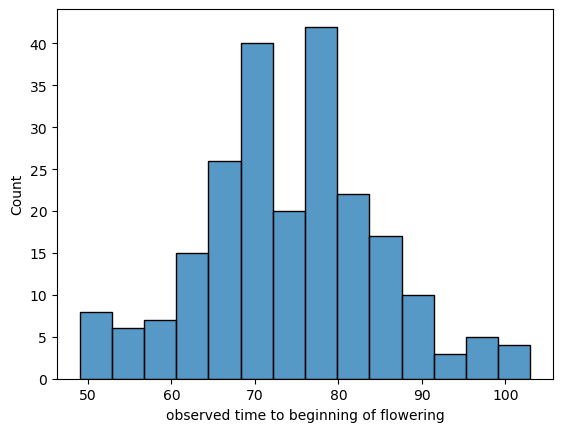

In [71]:
sns.histplot(ds_inputs_SSA['observed time to beginning of flowering'].loc[ds_inputs_SSA['observed time to beginning of flowering'] < 110])

In [87]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 200
k_folds = 5
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = LSTMClassifier_KG

#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 110]
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML.csv')
skip = 1
numsteps = int(183 // skip)

temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, NDVI_series_SSA)), 0, 1) #, photoperiod_series_SSA
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
input_dim = 2
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')

temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA)), 0, 1) #, photoperiod_series_SSA
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
input_dim = 3
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

loss_values_pp, R2s_pp, Biases_pp, Variances_pp = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')

Fold 1
Loss: 0.08549829572439194
Fold 2
Loss: 0.09602784365415573
Fold 3
Loss: 0.08620727807283401
Fold 4
Loss: 0.09464237093925476
Fold 5
Loss: 0.09403307735919952
Fold 1
Loss: 0.085512176156044
Fold 2
Loss: 0.0773744061589241
Fold 3
Loss: 0.09279321134090424
Fold 4
Loss: 0.09128756821155548
Fold 5
Loss: 0.08834605664014816


In [88]:
score = np.mean(loss_values_pp)
score_stde = np.std(loss_values_pp)/np.sqrt(5)
R2_score = np.mean(R2s_pp)
R2_stde = np.std(R2s_pp)/np.sqrt(5)
print(f'#### with photoperiod ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### without photoperiod ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### with photoperiod ####
loss 0.0934135526418686 +/- 0.008252814873061447
R2 0.38342068195343015 +/- 0.03112843001668959
#### without photoperiod ####
loss 0.09473170638084412 +/- 0.00830195625797501
R2 0.32801347970962524 +/- 0.04780631509988684


In [73]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 200
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = LSTMClassifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold', freeze_params=True)

model_class = LSTMClassifier_KG

loss_values_KG, R2s_KG, Biases_KG, Variances_KG = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')


Fold 1
Loss: 0.07798775285482407
Fold 2
Loss: 0.0751643180847168
Fold 3
Loss: 0.07241174578666687
Fold 4
Loss: 0.07308821380138397
Fold 5
Loss: 0.07203960418701172
Fold 1
Loss: 0.07121656090021133
Fold 2
Loss: 0.072046659886837
Fold 3
Loss: 0.07526375353336334
Fold 4
Loss: 0.07590906322002411
Fold 5
Loss: 0.07843251526355743


In [74]:
score = np.mean(loss_values_KG)
score_stde = np.std(loss_values_KG)/np.sqrt(5)
R2_score = np.mean(R2s_KG)
R2_stde = np.std(R2s_KG)/np.sqrt(5)
print(f'#### knowledge guided ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### not knowledge guided ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### knowledge guided ####
loss 0.07802475243806839 +/- 0.0026508789784144087
R2 0.43474254608154295 +/- 0.056153030260398654
#### not knowledge guided ####
loss 0.08154569715261459 +/- 0.005397475337998909
R2 0.3832476496696472 +/- 0.0731529722006318


In [ ]:
bs = 500
n_channels = 3
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
output_dim = 2  # Example: 5 classes

epochs = 200
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5

model_class = LSTMClassifier_KG

for num_layers in [20]:
    LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)
    loss_values_pp_DE, R2s_pp_DE, Biases_pp_DE, Variances_pp_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')
    score = np.mean(loss_values_pp_DE)
    score_stde = np.std(loss_values_pp_DE)/np.sqrt(5)
    R2_score = np.mean(R2s_pp_DE)
    R2_stde = np.std(R2s_pp_DE)/np.sqrt(5)
    print(f'#### {num_layers} layers ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

In [21]:
bs = 500
n_channels = 3
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
output_dim = 2  # Example: 5 classes

epochs = 200
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5

model_class = LSTMClassifier_KG

for num_layers in [7, 10, 14]:
    LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)
    loss_values_pp_DE, R2s_pp_DE, Biases_pp_DE, Variances_pp_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')
    score = np.mean(loss_values_pp_DE)
    score_stde = np.std(loss_values_pp_DE)/np.sqrt(5)
    R2_score = np.mean(R2s_pp_DE)
    R2_stde = np.std(R2s_pp_DE)/np.sqrt(5)
    print(f'#### {num_layers} layers ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

Fold 1
Loss: 0.07528859026138951
Fold 2
Loss: 0.0753291318194702
Fold 3
Loss: 0.076354987685485
Fold 4
Loss: 0.0784032944372247
Fold 5
Loss: 0.07682285143730948
#### 7 layers ####
loss 0.07848636358976364 +/- 0.0011462488251680115
R2 0.4440361261367798 +/- 0.02015191861962191
Fold 1
Loss: 0.07526788139535535
Fold 2
Loss: 0.07500631192012153
Fold 3
Loss: 0.07642222734358171
Fold 4
Loss: 0.07779240158712127
Fold 5
Loss: 0.07762233108178249
#### 10 layers ####
loss 0.079315884411335 +/- 0.0014667474234425191
R2 0.42253521680831907 +/- 0.024520114452263687
Fold 1


KeyboardInterrupt: 

In [17]:
bs = 2000
n_channels = 3
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
output_dim = 2  # Example: 5 classes

epochs = 200
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5

model_class = LSTMClassifier_KG

for num_layers in [4, 5, 6]:
    LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)
    loss_values_pp_DE, R2s_pp_DE, Biases_pp_DE, Variances_pp_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')
    score = np.mean(loss_values_pp_DE)
    score_stde = np.std(loss_values_pp_DE)/np.sqrt(5)
    R2_score = np.mean(R2s_pp_DE)
    R2_stde = np.std(R2s_pp_DE)/np.sqrt(5)
    print(f'#### {num_layers} layers ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')


Fold 1
Loss: 0.07677581161260605
Fold 2
Loss: 0.08046326041221619
Fold 3
Loss: 0.08035411685705185
Fold 4
Loss: 0.07957538962364197
Fold 5
Loss: 0.0790458545088768
#### 4 layers ####
loss 0.08020652532577514 +/- 0.0021230369263158986
R2 0.42160784006118773 +/- 0.023727084918986254
Fold 1
Loss: 0.0777832418680191
Fold 2
Loss: 0.08104202896356583
Fold 3
Loss: 0.08155226707458496
Fold 4
Loss: 0.07946819067001343
Fold 5
Loss: 0.07961277663707733
#### 5 layers ####
loss 0.08072238713502884 +/- 0.0021707134861668883
R2 0.41747000217437746 +/- 0.025360648796647053
Fold 1
Loss: 0.07692588865756989
Fold 2
Loss: 0.07857614010572433
Fold 3
Loss: 0.07952040433883667
Fold 4
Loss: 0.07780526578426361
Fold 5
Loss: 0.07999227195978165
#### 6 layers ####
loss 0.07921095490455628 +/- 0.002319786802838485
R2 0.440448534488678 +/- 0.026483459069260848


In [16]:
score = np.mean(loss_values_pp_DE)
score_stde = np.std(loss_values_pp_DE)/np.sqrt(5)
R2_score = np.mean(R2s_pp_DE)
R2_stde = np.std(R2s_pp_DE)/np.sqrt(5)
print(f'#### {num_layers} layers ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### 3 layers ####
loss 0.0793077677488327 +/- 0.0017332546501051074
R2 0.4335055470466614 +/- 0.010027238429591998


In [89]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 70
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5

model_class = LSTMClassifier_KG

temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, NDVI_series_DE)), 0, 1) #, photoperiod_series_SSA
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
input_dim = 2
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

loss_values_raw_DE, R2s_raw_DE, Biases_raw_DE, Variances_raw_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold', freeze_params = True)

temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #, photoperiod_series_SSA
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
input_dim = 3
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

loss_values_pp_DE, R2s_pp_DE, Biases_pp_DE, Variances_pp_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')



Fold 1
Loss: 0.08635916438119351
Fold 2
Loss: 0.07860278300518769
Fold 3
Loss: 0.08607490741385515
Fold 4
Loss: 0.0902995724156304
Fold 5
Loss: 0.08675887508363259
Fold 1
Loss: 0.08329663655632147
Fold 2
Loss: 0.07897472610890398
Fold 3
Loss: 0.08475084850319387
Fold 4
Loss: 0.08017050374848175
Fold 5
Loss: 0.08452773127925521


In [92]:
score = np.mean(loss_values_pp_DE)
score_stde = np.std(loss_values_pp_DE)/np.sqrt(5)
R2_score = np.mean(R2s_pp_DE)
R2_stde = np.std(R2s_pp_DE)/np.sqrt(5)
print(f'#### with photoperiod ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')
score = np.mean(loss_values_raw_DE)
score_stde = np.std(loss_values_raw_DE)/np.sqrt(5)
R2_score = np.mean(R2s_raw_DE)
R2_stde = np.std(R2s_raw_DE)/np.sqrt(5)
print(f'#### without photoperiod ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### with photoperiod ####
loss 0.08472762554883957 +/- 0.0018232777048941748
R2 0.34258193969726564 +/- 0.060628123371726246
#### without photoperiod ####
loss 0.08696865737438202 +/- 0.0022432350476922643
R2 0.30009658336639405 +/- 0.06407578442711574


In [146]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes
KG = False

epochs = 70
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1)
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = LSTMClassifier_KG

loss_values_raw_DE, R2s_raw_DE, Biases_raw_DE, Variances_raw_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold', freeze_params = True)

Fold 1


KeyboardInterrupt: 

In [107]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 70
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = LSTMClassifier_KG

loss_values_raw_DE, R2s_raw_DE, Biases_raw_DE, Variances_raw_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold', freeze_params = True)

model_class = LSTMClassifier_KG

loss_values_KG_DE, R2s_KG_DE, Biases_KG_DE, Variances_KG_DE = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold', freeze_params = False)


Fold 1
Loss: 0.09782727807760239
Fold 2
Loss: 0.1058533564209938
Fold 3
Loss: 0.1044757068157196
Fold 4
Loss: 0.10441369563341141
Fold 5
Loss: 0.10788612067699432
Fold 1
Loss: 0.09471262246370316
Fold 2
Loss: 0.10467568039894104
Fold 3
Loss: 0.09337598830461502
Fold 4
Loss: 0.09796919673681259
Fold 5
Loss: 0.09210525453090668


In [108]:
score = np.mean(loss_values_KG_DE)
score_stde = np.std(loss_values_KG_DE)/np.sqrt(5)
R2_score = np.mean(R2s_KG_DE)
R2_stde = np.std(R2s_KG_DE)/np.sqrt(5)
print(f'#### knowledge guided ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')
score = np.mean(loss_values_raw_DE)
score_stde = np.std(loss_values_raw_DE)/np.sqrt(5)
R2_score = np.mean(R2s_raw_DE)
R2_stde = np.std(R2s_raw_DE)/np.sqrt(5)
print(f'#### not knowledge guided ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### knowledge guided ####
loss 0.10262261480093002 +/- 0.00629576994485423
R2 0.31751677989959715 +/- 0.046082546105784286
#### not knowledge guided ####
loss 0.11052337884902955 +/- 0.00985863367801182
R2 0.20207531452178956 +/- 0.08112859021631272


In [48]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
output_dim = 2  # Example: 5 classes

epochs = 70
model_class = LSTMClassifier_KG
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)

k_folds = 5

for num_layers in [2]:
    for hidden_dim in [3, 8, 16]:
        LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, LSTM_args, savename_prefix = 'KFold')
        score = np.mean(loss_values)
        R2_score = np.mean(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score}\nR2 {R2_score}')

Fold 1


KeyboardInterrupt: 

In [97]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 200
k_folds = 5
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = LSTMClassifier_KG

#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 110]
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML.csv')

temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA)), 0, 1) #, photoperiod_series_SSA
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
input_dim = 3
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)
savename = 'LSTM_KG_SAT_pp'

loss_values_TL, R2s_TL, Biases_TL, Variances_TL = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, LSTM_args, savename_prefix = 'KFold')

Fold 1
Loss: 0.08309634774923325
Fold 2
Loss: 0.10379588603973389
Fold 3
Loss: 0.08337973058223724
Fold 4
Loss: 0.1165667474269867
Fold 5
Loss: 0.07193941622972488


In [98]:
score = np.mean(loss_values_TL)
score_stde = np.std(loss_values_TL)/np.sqrt(5)
R2_score = np.mean(R2s_TL)
R2_stde = np.std(R2s_TL)/np.sqrt(5)
print(f'#### using DE method and TL and less data ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### using DE method and TL and less data ####
loss 0.09541370868682861 +/- 0.001778796928849584
R2 0.3376558184623718 +/- 0.018782984012660486


In [96]:
score = np.mean(loss_values_TL)
score_stde = np.std(loss_values_TL)/np.sqrt(5)
R2_score = np.mean(R2s_TL)
R2_stde = np.std(R2s_TL)/np.sqrt(5)
print(f'#### using DE method and TL ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### using DE method and TL ####
loss 0.09429358243942261 +/- 0.008738943697756057
R2 0.36453646421432495 +/- 0.09124270698961687


In [105]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 100
k_folds = 5
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = LSTMClassifier_KG

#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 110]

temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #, photoperiod_series_SSA
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
input_dim = 3
LSTM_args = (input_dim, hidden_dim, num_layers, output_dim)
savename = 'LSTM_SSA_SAT_pp'

loss_values_TL_DE, R2s_TL_DE, Biases_TL_DE, Variances_TL_DE = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, LSTM_args, savename_prefix = 'KFold')

Fold 1
Loss: 0.0880794757887812
Fold 2
Loss: 0.09171997531663884
Fold 3
Loss: 0.09044198741861915
Fold 4
Loss: 0.09027949663458852
Fold 5
Loss: 0.09092758097507397


In [106]:
score = np.mean(loss_values_TL_DE)
score_stde = np.std(loss_values_TL_DE)/np.sqrt(5)
R2_score = np.mean(R2s_TL_DE)
R2_stde = np.std(R2s_TL_DE)/np.sqrt(5)
print(f'#### In DE, using SSA method and TL ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### In DE, using SSA method and TL ####
loss 0.09041881263256073 +/- 0.0023142412716396065
R2 0.29675562381744386 +/- 0.033784119502228864


In [101]:
input_dim = 4
savename = 'CCNN_KG_SAT_pp_SSA' #'LSTM_KG_SAT_pp'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, savename + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim) #LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
    param.requires_grad = True
#for param in model.fc.parameters():
#    param.requires_grad = False
#for param in model.lstm.parameters():
#    param.requires_grad = False
#for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
#    param.requires_grad = True
#for param in [model.u2]: #[model.u1, model.u2, model.u3]:
#    param.requires_grad = False


In [103]:
bs = 500
n_channels = 4
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.5)

# Loss function and optimizer
criterion = criterion = nn.BCELoss()#nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 20
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = 'CCNN_KG_pp_SSA_TL', CNN=True, bce = True)

0 0.09957191716124042 0.09839456334048809
5 0.09444774690689461 0.09756929126395471
10 0.09430861950526342 0.09742052598471268
15 0.09418401763628054 0.097313300903063


KeyboardInterrupt: 

In [233]:
model.u2

Parameter containing:
tensor([-0.7543], requires_grad=True)

0 0.575835919793519 0.2481135447032097
5 0.08617777853953089 0.08447731125611231
10 0.08263355924259588 0.08266838420203709
15 0.0825067298922613 0.08283769000590063
20 0.08238631203451947 0.08269778369868463


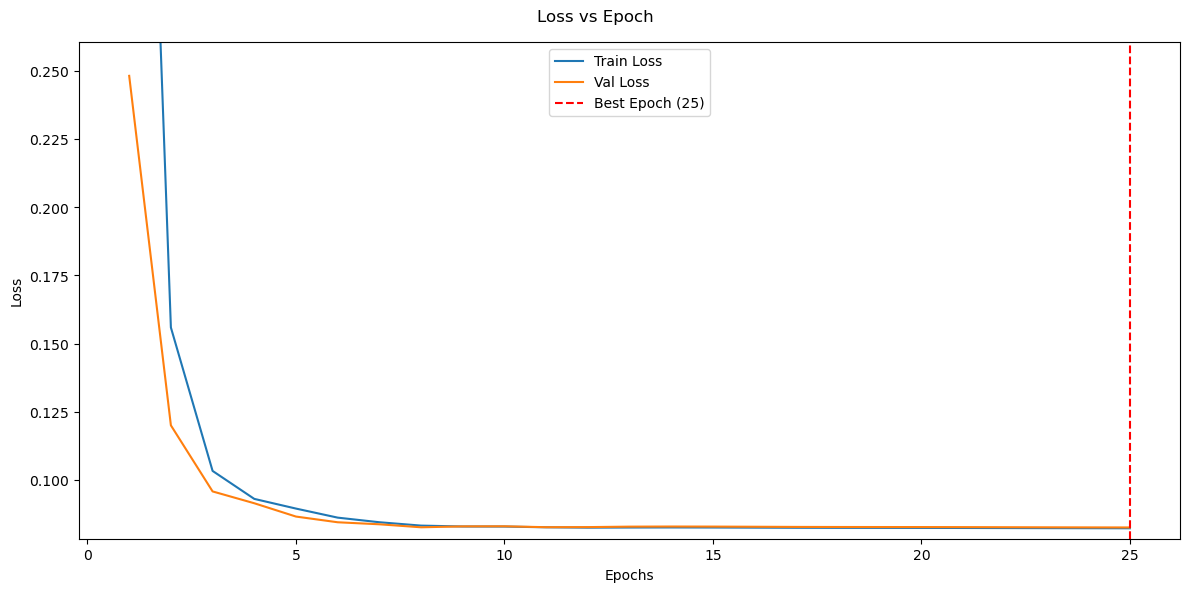

In [21]:
bs = 500
n_channels = 4
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

save_name = 'LSTM_KG_SAT_pp'

bce = False
CNN = False

model = LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG=True)
#for param in [model.u2]: #[model.u1, model.u2, model.u3]:
#    param.requires_grad = False

# Loss function and optimizer
if bce:
    criterion = nn.BCELoss()#weight = torch.Tensor([0.3, 0.7]))  #nn.CrossEntropyLoss# For multi-class classification
else:  
    criterion = nn.NLLLoss()#nn.BCELoss()#weight = torch.Tensor([0.3, 0.7]))  #nn.CrossEntropyLoss# For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 25
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, bce=bce)

OrderedDict([('u0', tensor([0.9108])), ('u1', tensor([0.0394])), ('u2', tensor([-0.3979])), ('u3', tensor([0.1823])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-1.8348e-01,  2.4470e-01,  2.4048e-01,  1.4995e-02],
        [-2.3228e-01, -3.5719e-01, -2.3018e-01,  1.3043e-01],
        [-8.7425e-02,  7.5415e-02,  5.7249e-01,  1.4542e-04],
        [-1.8038e-01,  1.1931e-01,  2.3615e-01, -1.2338e-01],
        [ 1.6548e-01, -1.1317e-01,  2.4741e-01,  2.5992e-01],
        [-2.7539e-01,  3.2682e-01, -1.2024e-01,  7.3375e-02],
        [ 3.3087e-02,  2.8596e-01,  2.7162e-01, -2.0499e-01],
        [-4.2666e-02, -3.5771e-01, -5.3937e-01,  1.6142e-01],
        [-8.4672e-02,  2.7828e-02,  1.5809e-01,  1.9655e-02],
        [-4.9486e-01,  1.4126e-01, -4.1349e-01, -1.8915e-02],
        [ 6.2235e-02,  5.1658e-01,  1.0834e-01,  2.5928e-01],
        [ 1.0406e-01,  6.0913e-03,  3.7722e-01, -2.0192e-01],
        [-2.3426e-01,  1.1790e-01,  5.4846e-01,  7.3132e-02],
        [-9.1929e-02, -1.8973e-

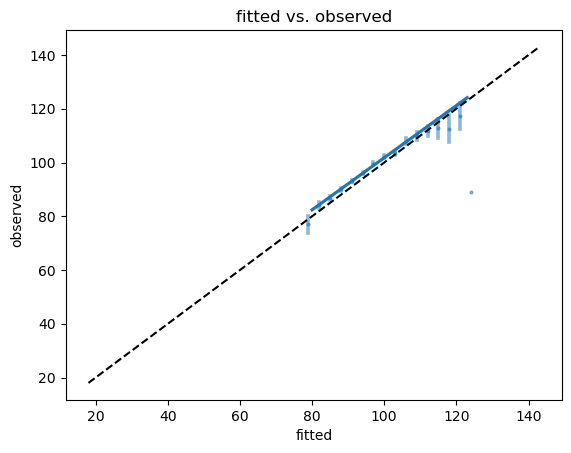

In [26]:
save_name = 'LSTM_KG_SAT_pp'

bce = False
CNN = False

temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA)), 0, 1)
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, train_dl, method = 'regression', bce=bce, CNN=CNN)#

In [83]:
comparison_frame = get_comparison_frame(save_name, model, val_dl, bce=bce, CNN=CNN)

In [85]:
comparison_frame['error'] = comparison_frame['fitted'] - comparison_frame['observed']
underestimate = comparison_frame.loc[comparison_frame['error'] < -15]
underestimate.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\underestimate.csv')
overestimate = comparison_frame.loc[comparison_frame['error'] > 15]
overestimate.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\overestimate.csv')
long_fitted = comparison_frame.loc[comparison_frame['fitted'] > 110]
long_fitted.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\long_fitted.csv')

In [64]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, 4, 0])
            list_stations.append(xb[:, 5, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [26]:
temp_NDVI_series_DE.shape

torch.Size([1434, 183, 3])

0 0.680184543132782 0.6744116544723511
5 0.6337686777114868 0.6006628274917603
10 0.4243524372577667 0.3624187707901001
15 0.23285983502864838 0.18864727020263672
20 0.1624758094549179 0.12415141612291336
25 0.18502575159072876 0.09542541205883026
30 0.14325402677059174 0.07613354176282883
35 0.12683722376823425 0.06959863007068634
40 0.1062454804778099 0.06556747853755951
45 0.10435265302658081 0.06822904944419861
50 0.10242033749818802 0.055775538086891174
55 0.10014453530311584 0.053795747458934784
60 0.09765453636646271 0.059455543756484985
65 0.09735105186700821 0.05879754200577736
70 0.0962098091840744 0.05251250043511391
75 0.09539392590522766 0.052493948489427567
80 0.09457936882972717 0.05498414486646652
85 0.09399275481700897 0.05251080542802811
90 0.09341144561767578 0.0518641360104084
95 0.09285755455493927 0.0522109754383564
100 0.09237780421972275 0.051772989332675934
105 0.09189949184656143 0.05078057944774628
110 0.09151681512594223 0.05183197930455208
115 0.09720073640

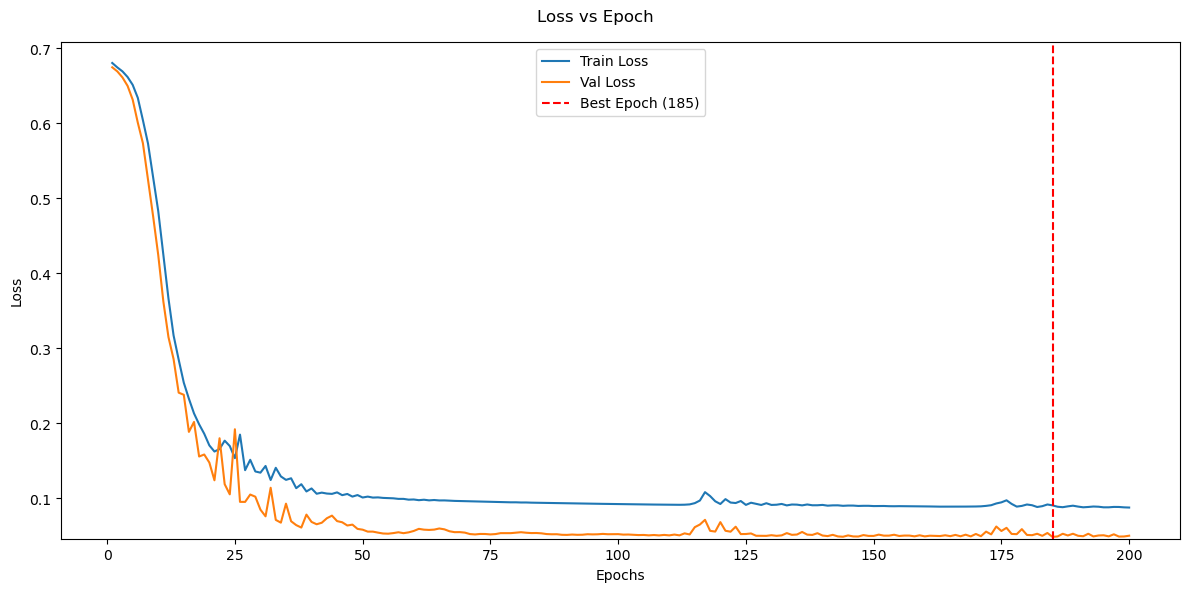

In [101]:
bs = 500
n_channels = 3
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion = 0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

model = LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)

#for param in [model.u0, model.u1, model.u2, model.u3]:
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = 'LSTM_SSA_SAT_pp')

OrderedDict([('u0', tensor([0.2466])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([12.5902])), ('lstm.weight_ih_l0', tensor([[ 8.8255e-01,  3.8715e-01,  9.6043e-01],
        [ 5.6568e-02, -1.9672e-01, -2.1095e-01],
        [ 1.0879e+00,  9.2101e-01,  1.5698e+00],
        [ 1.0070e+00,  7.4413e-01,  1.2972e+00],
        [ 1.1195e+00, -1.2306e-01,  1.5887e+00],
        [-4.5852e-02,  3.5395e-01,  2.8592e-01],
        [ 7.7995e-02,  1.4437e-01,  1.8232e-01],
        [ 3.5905e-01,  9.6417e-01,  6.5116e-01],
        [-7.6165e-02, -9.4379e-02, -1.5454e-02],
        [ 8.8549e-02,  4.0780e-01, -1.0398e-01],
        [ 4.9465e-01, -1.1587e-01,  5.0694e-01],
        [ 3.5527e-01,  2.1733e-03,  6.2580e-01],
        [ 6.7453e-02, -2.3593e-01,  1.3519e-01],
        [-3.8598e-02,  1.5523e-01,  5.6868e-01],
        [ 5.7598e-02,  3.7156e-01,  5.8227e-01],
        [ 5.3574e-01,  6.0680e-02, -8.8909e-01],
        [-2.7807e-01, -1.5131e+00,  6.3531e-01],
        [ 5.4

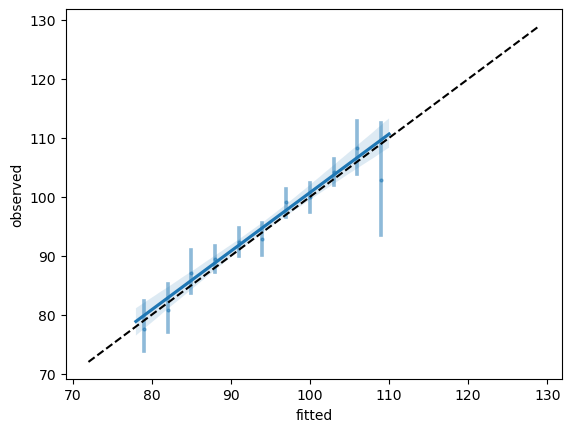

In [35]:
#train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.2)
plot_from_saved('LSTM_KG_SAT_pp', model, val_dl, method = 'regression', bce=False, CNN=False)#'Causal_CNN_KG_SAT_pp'

In [23]:
for x, y in val_dl:
    print(x.shape)

torch.Size([287, 3, 183])


In [165]:
T_min = 9 + 2*(torch.tanh(model.u1))
T_opt = 28 + 3*(torch.tanh(model.u2))
T_max = 39 + torch.tanh(model.u3)
print(T_min, T_opt, T_max)

tensor([8.2257], grad_fn=<AddBackward0>) tensor([26.4856], grad_fn=<AddBackward0>) tensor([39.5797], grad_fn=<AddBackward0>)


In [251]:
183 - plot_from_saved('LSTM1', model, val_dl).sum(dim=1)#.shape

tensor([ 92.,  74.,  98., 128.,  91.,  97., 102.,  93., 102.,  89.,  91.,  94.,
         98., 100., 103., 100., 104.,  81.,  99.,  78.,  80., 106.,  89., 103.,
        104., 105.,  87., 107.,  94.,  79.,  84.,  98., 110., 112.,  99.,  82.,
         81.,  73., 100.,  92.,  83.,  82.,  83.,  91.,  87., 102.,  98., 102.,
        104.,  98., 106.,  94.,  89.,  91., 114.,  91.,  93.,  96.,  79., 115.,
         82.,  91., 107.,  95.,  85., 105., 105., 101.,  79., 100.,  87.,  88.,
         80.,  86., 108.,  90., 101.,  79.,  81., 107.,  88., 106., 101.,  89.,
         91.,  98.,  94.,  92.,  94.,  92.,  97.,  94., 104., 103.,  94.,  96.,
        105., 107.,  82.,  80., 101.,  87., 102.,  96.,  95.,  82.,  89.,  84.,
        114.,  91.,  99., 106., 102., 102., 117.,  95.,  96.,  95., 102., 101.,
        101.,  95., 109.,  95., 101.,  88.,  99.,  96.,  93.,  85., 104., 132.,
         75.,  84., 105.,  96., 105., 111.,  94.,  88., 110., 101.,  94., 103.,
        112.,  86., 102., 123., 111., 11

OrderedDict([('u1', tensor([-1.0399])), ('u2', tensor([0.])), ('u3', tensor([1.8953])), ('lstm.weight_ih_l0', tensor([[ 0.3497],
        [ 1.4034],
        [ 0.2241],
        [ 0.1575],
        [ 0.8929],
        [-0.1015],
        [-0.4882],
        [-0.5783],
        [-0.1052],
        [-0.0884],
        [-0.0343],
        [ 0.6177]])), ('lstm.weight_hh_l0', tensor([[-0.5171, -0.2684, -0.1476],
        [-0.9054, -0.3538,  0.8354],
        [ 0.0356, -0.2734,  0.6736],
        [-0.3427, -0.9226,  0.2999],
        [-0.2274, -0.3574,  0.8647],
        [-0.7585, -0.4686,  0.5855],
        [ 0.8847,  0.3635, -0.5707],
        [ 0.7117,  0.8407, -0.5602],
        [-0.1836, -0.6859,  0.7178],
        [-1.0455,  0.0213,  0.8399],
        [-1.1573,  0.0522,  0.2889],
        [-0.3401, -0.2654,  0.9790]])), ('lstm.bias_ih_l0', tensor([ 1.6763,  1.6385,  1.1976,  0.0983,  0.4360,  0.4342, -0.6112, -1.4314,
         0.4771,  0.6225,  0.0912,  1.0859])), ('lstm.bias_hh_l0', tensor([ 0.9831,  1.679

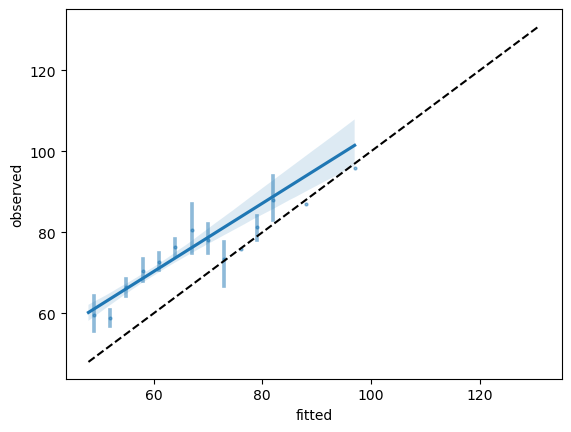

In [249]:
bs = 500
n_channels = 1
#train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
#train_dl, val_dl = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels)
#n_channels = 2
bs = 500
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 3
num_layers = 2
output_dim = 2  # Example: 5 classes

model = LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)

train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
fitted = plot_from_saved('LSTM_KG', model, val_dl_SSA, method = 'regression')

In [13]:
def cross_percentile_date(smoothed_series, percentile):
    # Calculate the 90th percentile
    percentile_value = np.percentile(smoothed_series, percentile)
    # Identify when the time series crosses the 90th percentile
    crosses_percentile_up = (smoothed_series > percentile_value).astype(int).diff().fillna(0) == 1#.astype(bool)
    crosses_percentile_down = (smoothed_series > percentile_value).astype(int).diff().fillna(0) == -1
    # Extract the dates when the crossing occurs
    crossing_dates_up = smoothed_series.index[crosses_percentile_up]
    crossing_dates_down = smoothed_series.index[crosses_percentile_down]
    return *crossing_dates_up, *crossing_dates_down
fitted.numpy()[5, :]

NameError: name 'fitted' is not defined

OrderedDict([('u0', tensor([1.1854])), ('u1', tensor([-0.4820])), ('u2', tensor([-0.8572])), ('u3', tensor([0.2272])), ('lstm.weight_ih_l0', tensor([[ 0.1217,  0.1681],
        [-0.0880, -0.3318],
        [ 0.3416,  0.6112],
        [-0.0069,  0.2185],
        [ 0.6464,  0.8143],
        [-0.1818, -0.1836],
        [ 0.0231, -0.0755],
        [ 0.4883,  0.6135],
        [ 0.3315,  0.2868],
        [-0.1409,  0.2499],
        [ 0.1236,  0.4773],
        [ 0.1268, -0.4379],
        [ 0.5097,  0.4219],
        [ 0.0818, -0.0723],
        [ 0.0975, -0.3854],
        [-0.0178,  0.3950],
        [-0.2760, -0.2889],
        [ 0.5721,  0.6007],
        [ 0.5916,  0.7739],
        [ 0.0553, -0.2084],
        [-0.8049, -0.5069],
        [-0.1863, -0.4918],
        [-0.0657, -0.1003],
        [-0.5945, -0.1417],
        [-0.0455, -0.2801],
        [ 0.6516,  0.4984],
        [-0.1297,  0.1685],
        [ 0.0371,  0.3060],
        [-0.1077,  0.1188],
        [ 0.3715,  0.6106],
        [ 0.0805, -

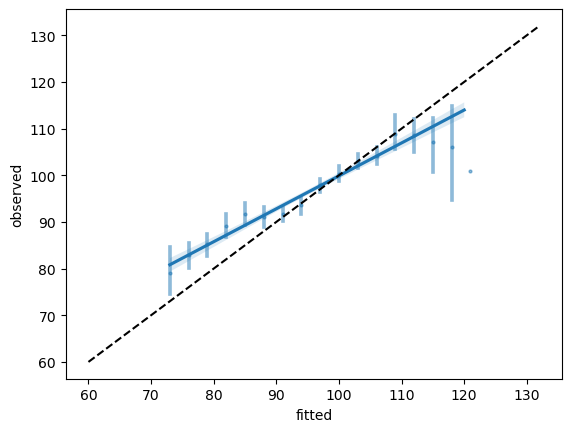

In [77]:
plot_from_saved('LSTM_KG_TL_DE', model, val_dl, method = 'regression')

R^2 value for model: -0.022724151611328125
Bias: 0.7749993004318797
Variance of modelled values: 134.99668023916942


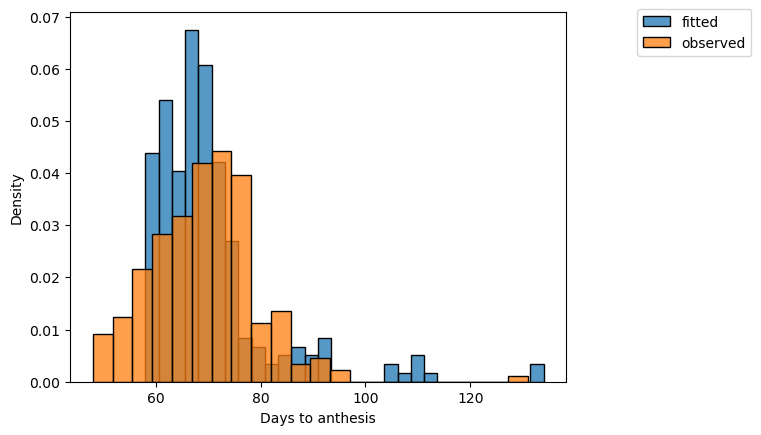

In [103]:
plot_from_saved('LSTM_temp', model, val_dl_SSA, method = 'histogram')

In [99]:
bs = 2000
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [57]:
bs = 2000
n_channels = 1
skip = 4
numsteps = int(199 // skip)
temp_series_DE = torch.Tensor(ds_inputs_DE[[f't2m at day {n*skip}' for n in range(numsteps)]].values)
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

In [89]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

0 96.84303283691406 96.87023162841797
R2 on train set: -76.62422180175781
R2 on test set: -71.15215301513672
5 96.77468872070312 96.75077056884766
R2 on train set: -76.51470184326172
R2 on test set: -70.97431182861328
10 96.3301773071289 96.221923828125
R2 on train set: -75.80424499511719
R2 on test set: -70.18962097167969
15 95.32610321044922 95.02777862548828
R2 on train set: -74.21148681640625
R2 on test set: -68.4336166381836
20 90.5361328125 85.08609771728516
R2 on train set: -66.8428955078125
R2 on test set: -54.66546630859375
25 72.37852478027344 40.58394241333008
R2 on train set: -42.35906982421875
R2 on test set: -11.664180755615234
30 96.97423553466797 91.8770523071289
R2 on train set: -76.8346939086914
R2 on test set: -63.90568542480469
35 106.55482482910156 114.25272369384766
R2 on train set: -92.97378540039062
R2 on test set: -99.36949920654297
40 142.76829528808594 145.8023681640625
R2 on train set: -167.7034912109375
R2 on test set: -162.454833984375
45 97.28972625732422

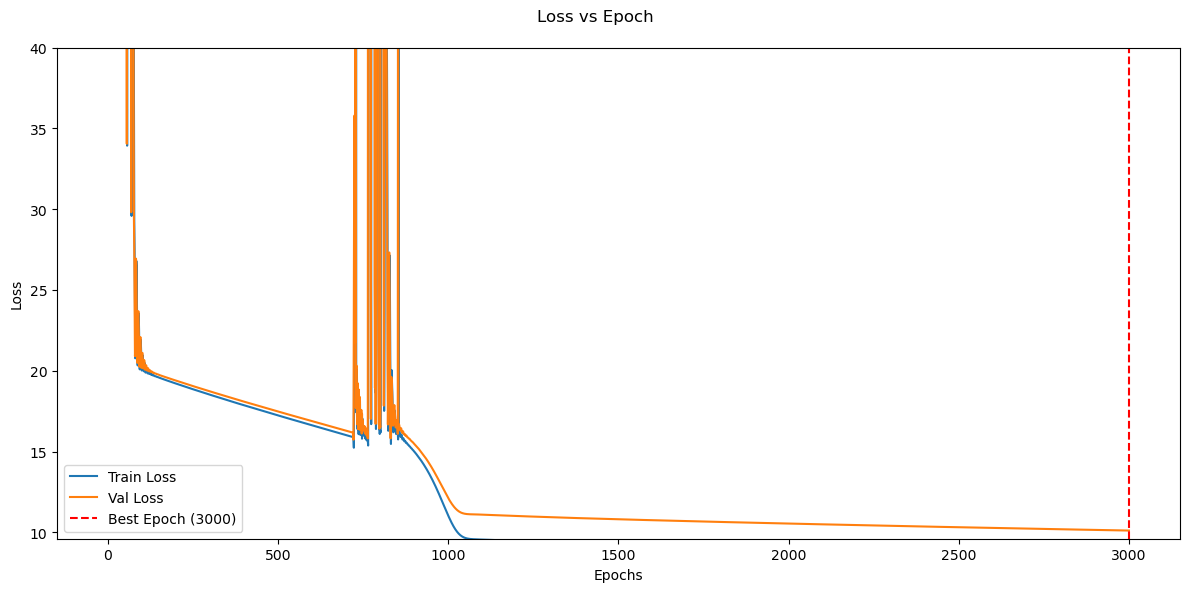

In [13]:
bs = 500
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(21, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

lr = 0.03
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#opt = optim.Adam(model.parameters(), lr=lr)
epochs = 3000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='temp_and_NDVI2')

R^2 value for model: -3.1147475242614746
Bias: 141.29671261938347
Variance of modelled values: 126.1581802368164


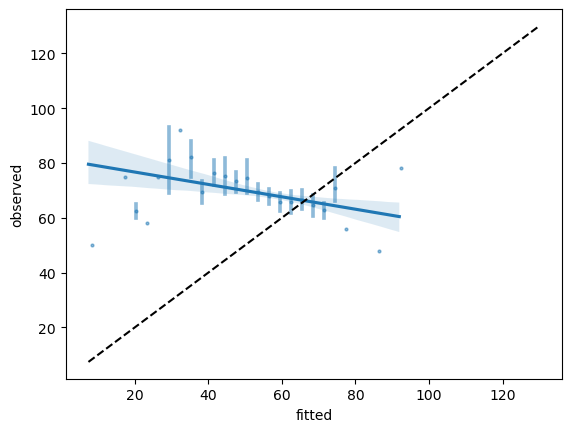

In [12]:
#train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
plot_from_saved('Temp_and_NDVI2', model, val_dl_SSA)

R^2 value for model: 0.10036206245422363
Bias: 1.8609495842829347
Variance of modelled values: 10.677059173583984


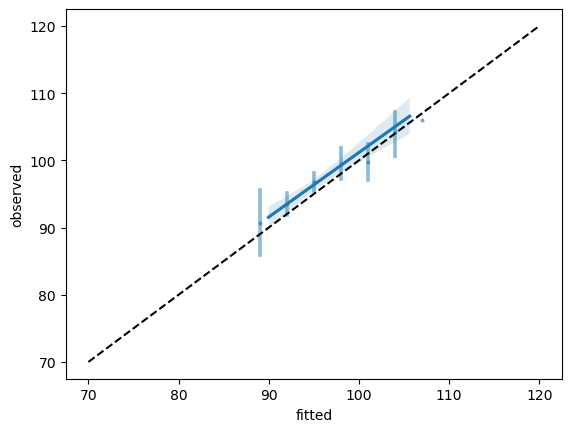

In [48]:
#train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model2 = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 2, kernel_size=5, dilation=6, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
#    nn.Conv1d(3, 3, kernel_size=3, padding=1),
#    nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(2, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),#nn.Linear(numsteps, 1)#
    Lambda(lambda x: x.view(x.size(0), -1)),
) 

model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, 'NDVI_CNN' + ".pt")

checkpoint = torch.load(model_path, weights_only=True)
model2.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plot_fitted_observed(model2, val_dl)

In [81]:
torchinfo.summary(model)#.eval()

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv1d: 1-1                            11
├─LeakyReLU: 1-2                         --
├─Conv1d: 1-3                            4
├─LeakyReLU: 1-4                         --
├─AdaptiveAvgPool1d: 1-5                 --
├─Lambda: 1-6                            --
Total params: 15
Trainable params: 15
Non-trainable params: 0

In [82]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}")

Parameter name: 0.weight
Parameter value: Parameter containing:
tensor([[[  7.1422,  -2.4835,  -2.7349,   1.2524,  -4.4099],
         [  5.1709,  -0.2092, -10.8349,  -1.1365,  -3.4423]]],
       requires_grad=True)
Parameter name: 0.bias
Parameter value: Parameter containing:
tensor([-40.6502], requires_grad=True)
Parameter name: 2.weight
Parameter value: Parameter containing:
tensor([[[-2.5403, -1.5112, -0.5888]]], requires_grad=True)
Parameter name: 2.bias
Parameter value: Parameter containing:
tensor([111.1209], requires_grad=True)


In [18]:
def plot_all_channels(X, fig, ax):
    for channel_index in range(X.shape[0]):
        ax.plot(X[channel_index, :])

In [19]:
def plot_each_layer(TS_model, X):
    layers = list(TS_model.children())
    fig, axs = plt.subplots(len(layers) + 1, 1, figsize = (3, 10))
    plot_all_channels(X, fig, axs[0])
    X_at_layer = X
    for layer_index, layer in enumerate(layers):
        ax = axs[layer_index + 1]
        with torch.no_grad():
            X_at_layer = layer(X_at_layer)
        plot_all_channels(X_at_layer, fig, ax)


In [72]:
with torch.no_grad():
    print(AP(RU2(C2(RU1(C1(temp_NDVI_series_DE[0, :, :]))))))

tensor([[91.1205]])


0 96.38427734375 93.2884521484375
R2 on train set: -92.55133819580078
R2 on test set: -81.62979888916016
5 62.67894744873047 107.28910827636719
R2 on train set: -38.562252044677734
R2 on test set: -108.29296875
10 32.44706344604492 43.75981521606445
R2 on train set: -9.602014541625977
R2 on test set: -17.181591033935547
15 20.98536491394043 32.64659881591797
R2 on train set: -3.434765338897705
R2 on test set: -9.119447708129883
20 24.758493423461914 28.597997665405273
R2 on train set: -5.172854423522949
R2 on test set: -6.765191555023193
25 24.469512939453125 25.29242515563965
R2 on train set: -5.02959680557251
R2 on test set: -5.073819637298584
30 19.683284759521484 26.15377426147461
R2 on train set: -2.90151047706604
R2 on test set: -5.494558811187744
35 19.547494888305664 21.08934211730957
R2 on train set: -2.847865104675293
R2 on test set: -3.222862720489502
40 18.2839298248291 20.21169090270996
R2 on train set: -2.366485118865967
R2 on test set: -2.8787002563476562
45 17.562793731

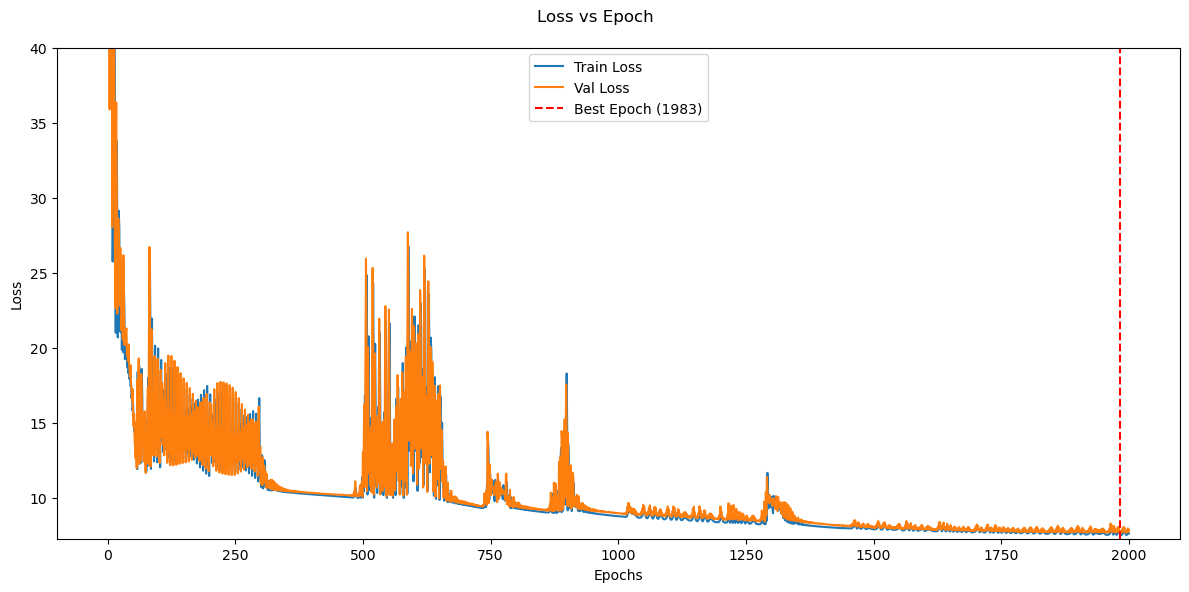

In [124]:
bs = 2000
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(temp_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=5, dilation=2, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 2, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(14, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.05
#model = phen_CNN_1d()
#opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 2000
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='temp_CNN3')

R^2 value for model: -0.34430789947509766
Bias: 49.77136073321162
Variance of modelled values: 113.59953308105469


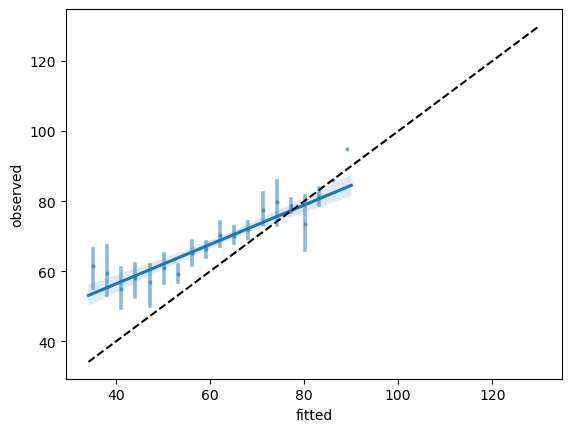

In [77]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
plot_from_saved('Temp_CNN2', model, val_dl_SSA)

In [ ]:
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 2, kernel_size=5, dilation=6, padding=7),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    #nn.Conv1d(3, 3, kernel_size=3, padding=1),
    #nn.LeakyReLU(negative_slope=0.01),
    nn.Conv1d(2, 1, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AdaptiveAvgPool1d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

R^2 value for model: 0.3563251495361328
Bias: 0.4535612259642221
Variance of modelled values: 35.384422302246094


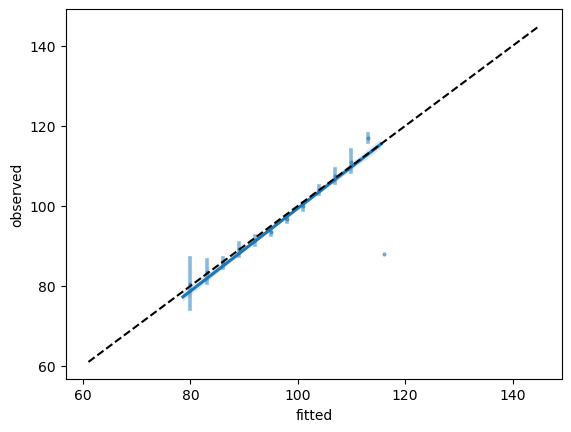

In [92]:
plot_from_saved('Temp_NDVI_CNN', model, val_dl)

In [82]:
temp_series_DE.shape

torch.Size([9838, 183])

In [119]:
bs = 500
n_channels = 2
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(21, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='Temp_NDVI_CNN')

AssertionError: Size mismatch between tensors

0 69.37451171875 67.8327865600586
R2 on train set: -42.9195442199707
R2 on test set: -53.61483383178711
5 59.34967803955079 46.80571365356445
R2 on train set: -31.143611907958984
R2 on test set: -25.003334045410156
10 17.933143615722656 10.845736503601074
R2 on train set: -1.9347476959228516
R2 on test set: -0.3962055444717407
15 11.519375801086426 15.851170539855959
R2 on train set: -0.210921049118042
R2 on test set: -1.9823181629180908
20 14.561492919921875 12.990528106689453
R2 on train set: -0.9349501132965088
R2 on test set: -1.0030181407928467
25 13.514237403869627 11.005656242370605
R2 on train set: -0.6666370630264282
R2 on test set: -0.43768310546875
30 11.399699211120605 11.144886016845703
R2 on train set: -0.18589091300964355
R2 on test set: -0.4742887020111084
35 11.845677375793457 10.230749130249023
R2 on train set: -0.2804945707321167
R2 on test set: -0.2423563003540039
40 11.311026573181152 9.818648338317871
R2 on train set: -0.16751372814178467
R2 on test set: -0.144286

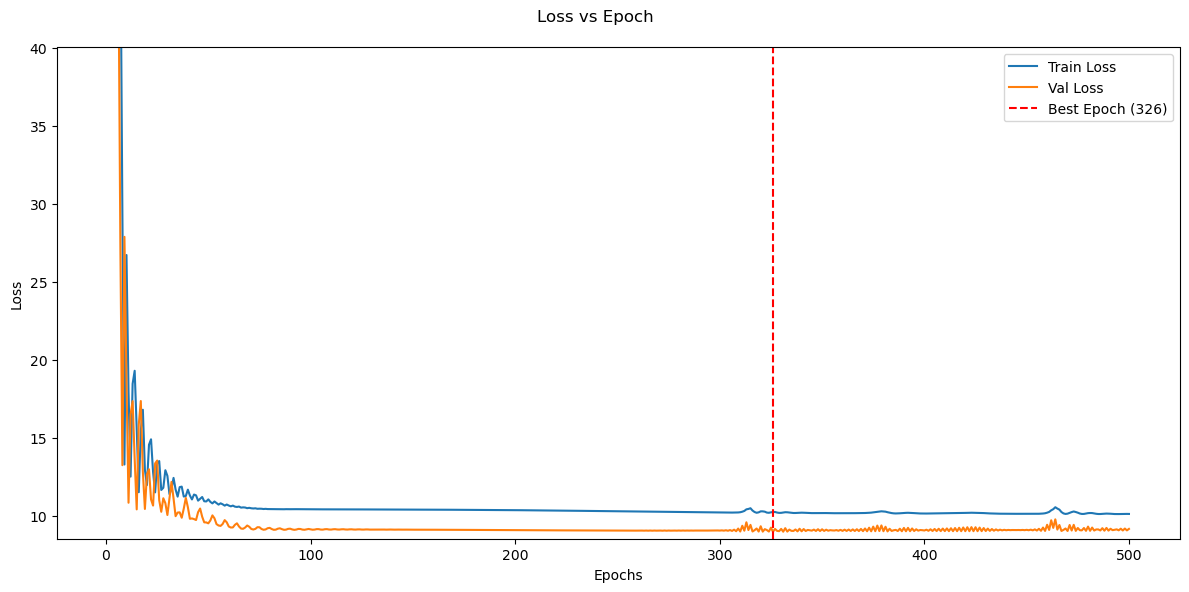

In [15]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(21, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='NDVI_CNN')

R^2 value for model: -5.707334995269775
Bias: 585.5852026978973
Variance of modelled values: 23.180936813354492


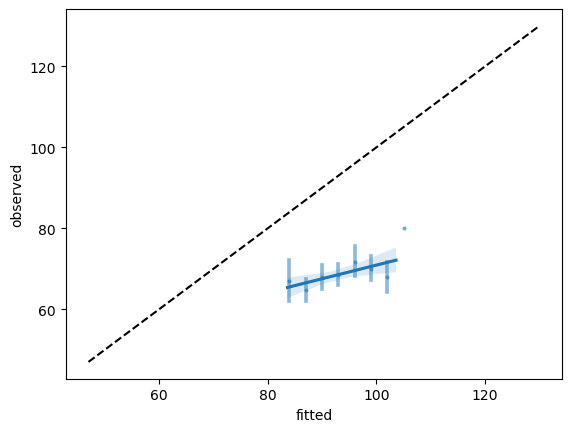

In [116]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0)
plot_from_saved('GDD_NDVI_CNN', model, val_dl_SSA)

In [105]:
ds_inputs_DE

,Unnamed: 0,year,Stations_id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 8,NDVI interpolated at day 16,NDVI interpolated at day 24,NDVI interpolated at day 32,NDVI interpolated at day 40,...,NDVI interpolated at day 260,NDVI interpolated at day 261,NDVI interpolated at day 262,NDVI interpolated at day 263,NDVI interpolated at day 265,NDVI interpolated at day 266,NDVI interpolated at day 267,NDVI interpolated at day 268,NDVI interpolated at day 269,maxday
19,188.0,2018,7521.0,2018-02-18,0.320304,0.323722,0.330771,0.341449,0.371024,0.384390,...,0.591544,0.596834,0.602124,0.607414,0.619792,0.626881,0.633970,0.641058,0.648147,136
20,151.0,2019,7521.0,2019-02-18,0.524035,0.506643,0.500193,0.504684,0.521082,0.544190,...,0.604712,0.602203,0.599695,0.597187,0.592372,0.590066,0.587760,0.585454,0.583148,168
21,114.0,2020,7521.0,2020-02-18,0.530496,0.506531,0.491904,0.486614,0.512788,0.517554,...,0.581658,0.584183,0.586709,0.589234,0.597541,0.603322,0.609103,0.614885,0.620666,208
22,75.0,2021,7521.0,2021-02-18,0.425831,0.444292,0.464603,0.486765,0.498273,0.530083,...,0.535018,0.533659,0.532301,0.530942,0.531344,0.533104,0.534865,0.536625,0.538385,152
23,37.0,2022,7521.0,2022-02-18,0.255260,0.354114,0.432829,0.491404,0.507362,0.530332,...,0.586019,0.582100,0.578180,0.574261,0.564436,0.558530,0.552624,0.546718,0.540812,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21417,62.0,2021,19585.0,2021-02-18,0.461548,0.498599,0.525763,0.543039,0.542019,0.552136,...,0.568327,0.564398,0.560470,0.556541,0.548578,0.544544,0.540509,0.536475,0.532441,152
21418,26.0,2022,19585.0,2022-02-18,0.496610,0.527470,0.549909,0.563928,0.549505,0.561102,...,0.565575,0.572492,0.579409,0.586327,0.602216,0.611187,0.620159,0.629131,0.638102,144
21436,212.0,2017,19587.0,2017-02-18,0.425085,0.427672,0.446832,0.482566,0.549552,0.620637,...,0.602370,0.601895,0.601420,0.600946,0.601043,0.601616,0.602189,0.602761,0.603334,96
21503,174.0,2018,19700.0,2018-02-18,0.105831,0.221034,0.303757,0.354002,0.346518,0.285715,...,0.534139,0.539760,0.545381,0.551002,0.564852,0.573080,0.581309,0.589537,0.597766,144


In [33]:
NDVI_series_DE.shape

torch.Size([2380, 65])

0 98.18644301962925 96.3691635131836
R2 on train set: -80.85773468017578
R2 on test set: -77.05242919921875
5 41.90771146395453 15.667854309082031
R2 on train set: -13.912298202514648
R2 on test set: -1.0631427764892578
10 22.35223292423864 14.289529800415039
R2 on train set: -3.24227237701416
R2 on test set: -0.7161139249801636
15 14.279389490593287 11.121830940246582
R2 on train set: -0.7313146591186523
R2 on test set: -0.03959167003631592
20 10.480188671262205 12.281865119934082
R2 on train set: 0.06740105152130127
R2 on test set: -0.2677654027938843
25 10.795738721815766 10.856291770935059
R2 on train set: 0.010396003723144531
R2 on test set: 0.009457170963287354
30 10.290813680222124 10.92855167388916
R2 on train set: 0.10080033540725708
R2 on test set: -0.0037728548049926758
35 10.127608115329272 10.82460880279541
R2 on train set: 0.12909561395645142
R2 on test set: 0.015230357646942139
40 10.032753157642974 10.760037422180176
R2 on train set: 0.145332932472229
R2 on test set: 0.

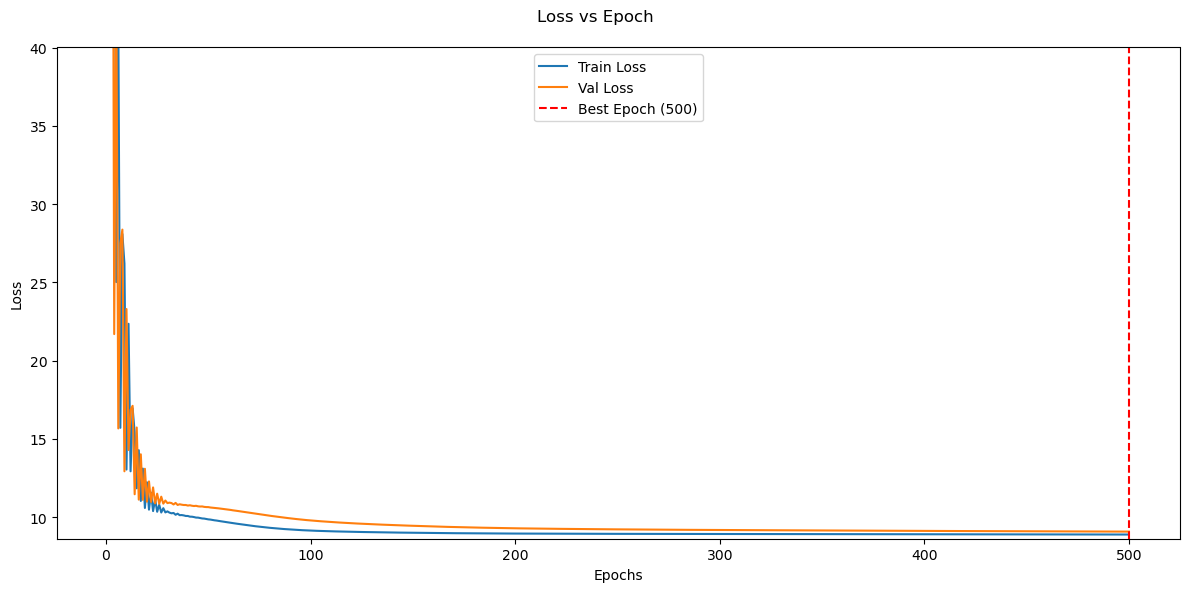

In [16]:
bs = 500
n_channels = 1
train_dl, val_dl = train_test_dl_from_tensors(NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)# - 0.5
model = nn.Sequential(
#    Lambda(preprocess),
    nn.Conv1d(n_channels, 3, kernel_size=3, dilation=1, padding=12),#stride=3, 
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=2),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(3, 3, kernel_size=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01),
    nn.AvgPool1d(kernel_size=3),
    nn.Flatten(),
    nn.Linear(9, 1),
    nn.LeakyReLU(negative_slope=0.01),
    #nn.AdaptiveAvgPool1d(1),
    #Lambda(lambda x: x.view(x.size(0), -1)),
)
lr = 0.1
#model = phen_CNN_1d()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=lr)
epochs = 500
loss_func = F.mse_loss
fit(epochs, model, loss_func, opt, train_dl, val_dl, save_name='GDD_NDVI_CNN')

In [170]:
val_dl.dl.dataset.dataset

In [175]:
for xb, yb in val_dl:
    with torch.no_grad():
        print(torch.cat((model(xb), model(xb))).shape)

torch.Size([688, 1])


In [184]:
observed.numpy().squeeze().shape

(344,)

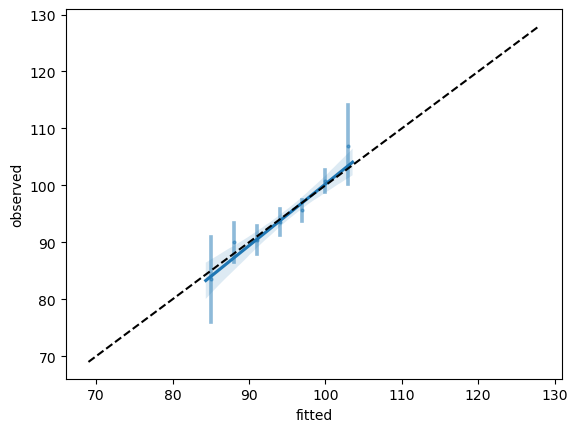

In [193]:
plot_fitted_observed(model, val_dl)


In [49]:
model, opt = get_model()
print(loss_func(model(xb), yb))

In [ ]:
NDVI_series = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {n*4}' for n in range(25)]].values)
temp_series = torch.Tensor(ds_inputs_SSA[[f'temperature at day {n*4}' for n in range(25)]].values)
temp_NDVI_series = torch.swapaxes(torch.stack((temp_series, NDVI_series)), 0, 1)

In [58]:
in_channels = 2
out_channels = 4
Kernel_size = 4
c = torch.nn.Conv1d(in_channels, out_channels, Kernel_size)

In [61]:
temp_NDVI_series.shape

torch.Size([240, 2, 25])

In [60]:
c(temp_NDVI_series).shape

torch.Size([240, 4, 22])

In [33]:
ds_inputs_DE.dropna(how='any')[['Day of start', 'WC SOS date']]

# Note to self: start NDVI a bit along

,Day of start,WC SOS date
19,2018-04-03,2018-04-15
20,2019-04-03,2019-04-15
21,2020-04-02,2020-04-14
22,2021-04-03,2021-04-15
23,2022-04-03,2022-04-15
...,...,...
21500,2021-04-03,2021-04-15
21501,2022-04-03,2022-04-15
21519,2017-04-03,2017-04-17
21586,2018-04-03,2018-04-18


In [75]:
from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]


#dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [76]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train, test = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(train, batch_size=len(train), train=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#trainset = torch.utils.data.DataLoader(test, batch_size=len(test), train=False, transform=transform)
trainset = PandasDataset(train)
testset = PandasDataset(test)
 
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
 
class CNN1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 20, kernel_size=4, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(128, 16)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(64, 16)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CNN1d()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 10
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
torch.save(model.state_dict(), "cifar10model.pth")

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'pandas.core.series.Series'>